# Project: Service Cancellation Prediction

## Team Information
- **Team Name:** Team C
- **Semester:** Big Data Fall 2023
- **Section:** B

## Team Members
1. Manyu Dhyani - 20015463
2. Kshitij Kiran Chaudhari - 20011209
3. Chakravarti Kothadiya – 20012229
4. Sarthak Vaidya – 20016184

## Problem Statement
The streaming industry is grappling with a notable surge in subscription cancellations, impacting both music streaming services and Over-The-Top (OTT) platforms. Recent surveys have unveiled a concerning trend, with approximately 19% of users opting to cancel their subscriptions, often taking advantage of free trial periods.

## Project Objective
Our project is dedicated to addressing this challenge by leveraging user interaction data for predictive modeling. The primary goal is to develop an solution for detecting service cancellations. The focus will be on categorizing users into two main groups: "Not Cancelled" and "Cancelled."

## Approach
To achieve our objective, we will employ advanced analytics and machine learning techniques on the streaming platform's user interaction data. The project's success hinges on developing a robust predictive model that can accurately identify users at risk of canceling their subscriptions.


In [ ]:
# Building Spark Session
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
  .appName('Spotify BigData') \
  .getOrCreate()

In [ ]:
# Here the paths are simplified. Before runnnig notebook on cluster set gs path according to the cloud Storage, like here it was gs://Bucket_Name/spotify_3M.csv.
spotify = spark \
  .read \
  .option ( "inferSchema" , "true" ) \
  .option ( "header" , "true" ) \
  .csv ( 'spotify_3M.csv' )

spotify.printSchema()

root
 |-- status: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- length: double (nullable = true)
 |-- firstName: string (nullable = true)
 |-- level: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- userId: integer (nullable = true)
 |-- ts: long (nullable = true)
 |-- auth: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- itemInSession: integer (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- song: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- method: string (nullable = true)



In [ ]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import time

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, LongType

from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MaxAbsScaler

from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType

from pyspark.ml.recommendation import ALS

from pyspark.ml.linalg import Vectors
from pyspark.mllib.linalg.distributed import CoordinateMatrix, IndexedRowMatrix

# Loading and Data Pre-Processing

In [ ]:
# Define the schema for the CSV file
schema = StructType([
    StructField("status", IntegerType(), True),
    StructField("gender", StringType(), True),
    StructField("length", DoubleType(), True),
    StructField("firstName", StringType(), True),
    StructField("level", StringType(), True),
    StructField("lastName", StringType(), True),
    StructField("registration", DoubleType(), True),
    StructField("userId", LongType(), True),
    StructField("ts", DoubleType(), True),
    StructField("auth", StringType(), True),
    StructField("page", StringType(), True),
    StructField("sessionId", IntegerType(), True),
    StructField("location", StringType(), True),
    StructField("itemInSession", IntegerType(), True),
    StructField("userAgent", StringType(), True),
    StructField("song", StringType(), True),
    StructField("artist", StringType(), True),
    StructField("method", StringType(), True)
])

# Read the CSV file with the defined schema
#df = spark.read.csv("dbfs:/FileStore/spotify_250.csv", header=True, schema=schema)
df = spark.read.csv('spotify_3M.csv', header=True, schema=schema)
print(df.count())

# Create a temporary view for Spark SQL operations
df.createOrReplaceTempView("sparkify_events")

# Clean the dataset
# Remove rows where userId or sessionId is NULL
df = spark.sql("""
    SELECT userId, gender, length, firstName, level, lastName, registration, ts,
    auth, page, sessionId, location, itemInSession, userAgent, song, artist, method
    FROM sparkify_events
    WHERE userId IS NOT NULL AND sessionId IS NOT NULL
    ORDER BY userId, ts
""")

df.createOrReplaceTempView("sparkify_events")
df.show()


3000000


+-------+------+---------+---------+-----+--------+--------------+--------------+---------+---------------+---------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+
| userId|gender|   length|firstName|level|lastName|  registration|            ts|     auth|           page|sessionId|            location|itemInSession|           userAgent|                song|              artist|              method|
+-------+------+---------+---------+-----+--------+--------------+--------------+---------+---------------+---------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+
|1000025|     M|     null|   Camren| free|  Walker|1.531215008E12|1.538470769E12|Logged In|           Home|    23706|New Haven-Milford...|            0|"""Mozilla/5.0 (W...| like Gecko) Chro...|                null|                null|
|1000025|     M|251.97669|   Camren| free|  Walker|1

In [ ]:
# Get the count of the DataFrame after filter
df_count = df.count()
print("DataFrame Count:", df_count)

DataFrame Count: 3000000


In [ ]:
# Select and print the specified columns for the first 5 rows
df.select("userId", "gender", "location", "level", "sessionId", "page",
          "artist", "song", "length", "userAgent", "registration", "ts").show(5)

+-------+------+--------------------+-----+---------+--------+------------+--------------------+---------+--------------------+--------------+--------------+
| userId|gender|            location|level|sessionId|    page|      artist|                song|   length|           userAgent|  registration|            ts|
+-------+------+--------------------+-----+---------+--------+------------+--------------------+---------+--------------------+--------------+--------------+
|1000025|     M|New Haven-Milford...| free|    23706|    Home|        null| like Gecko) Chro...|     null|"""Mozilla/5.0 (W...|1.531215008E12|1.538470769E12|
|1000025|     M|New Haven-Milford...| free|    23706|NextSong| Underground| like Gecko) Chro...|251.97669|"""Mozilla/5.0 (W...|1.531215008E12|1.538470964E12|
|1000025|     M|New Haven-Milford...| free|    23706|NextSong|AsesÃÂ­name| like Gecko) Chro...|223.05914|"""Mozilla/5.0 (W...|1.531215008E12|1.538471215E12|
|1000025|     M|New Haven-Milford...| free|    23706

The first step is to process the unique indexes that we will use. In this case, is the “userId” and “artist”.

Several rows have null “artist”, and thus we let the Spark indexer handle these as a separate category with a single identification number, so it does not drop those columns. This is necessary, as only the events of the page “NextSong” have artist.

In [ ]:
# Create Indexer for userId and artist
# The purpose of StringIndexer is to convert categorical string columns into numerical indices
# The "userIdIndex" is created based on the categorical nature of the "userId" column
user_indexer = StringIndexer(inputCol="userId", outputCol="userIdIndex")
artist_indexer = StringIndexer(inputCol="artist", outputCol="artistIndex", handleInvalid="keep")

# Create labels for user and artist
user_indexer_model = user_indexer.fit(df)
artist_indexer_model = artist_indexer.fit(df)

# Transform dataframe
df = user_indexer_model.transform(df)
df = artist_indexer_model.transform(df)
df.createOrReplaceTempView("sparkify_events")

In [ ]:
result = spark.sql("SELECT userId, userIdIndex, artist, artistIndex FROM sparkify_events")
result.show()

+-------+-----------+--------------------+-----------+
| userId|userIdIndex|              artist|artistIndex|
+-------+-----------+--------------------+-----------+
|1000025|      357.0|                null|   161930.0|
|1000025|      357.0|         Underground|     1797.0|
|1000025|      357.0|        AsesÃÂ­name|     4699.0|
|1000025|      357.0|           Last Nite|     1728.0|
|1000025|      357.0|             The End|     1481.0|
|1000025|      357.0|                null|   161930.0|
|1000025|      357.0|          Just Dance|       84.0|
|1000025|      357.0|           Starshine|     4886.0|
|1000025|      357.0|Comatose (Comes A...|     2657.0|
|1000025|      357.0|                null|   161930.0|
|1000025|      357.0|Waiting For The N...|    16790.0|
|1000025|      357.0|                null|   161930.0|
|1000025|      357.0|Won't Turn Back (...|    31569.0|
|1000025|      357.0|    Suspicious Minds|     4287.0|
|1000025|      357.0|             Valerie|      913.0|
|1000025| 

Now we created a "elapsed" column. The value this represent is the time elapsed since the user's registration. ts - registration. Then we are creating two new columns: "timestamp" and "registration_date".

It converts Unix timestamps (in milliseconds) in the "ts" and "registration" columns to Spark's TimestampType using the from_unixtime and to_timestamp functions. The division by 1000 is necessary because Unix timestamps are typically in seconds, and Spark expects timestamps in seconds rather than milliseconds.

In [ ]:
# Convert timestamp
# Creating
df = df.withColumn("elapsed", df.ts - df.registration)
df = df.withColumn("timestamp", F.to_timestamp(F.from_unixtime(df.ts/1000)))
df = df.withColumn("registration_date", F.to_timestamp(F.from_unixtime(df.registration/1000)))
df.createOrReplaceTempView("sparkify_events")

In [ ]:
result = spark.sql("SELECT elapsed, timestamp, registration_date FROM sparkify_events")
result.show()

+----------+-------------------+-------------------+
|   elapsed|          timestamp|  registration_date|
+----------+-------------------+-------------------+
|7.255761E9|2018-10-02 08:59:29|2018-07-10 09:30:08|
|7.255956E9|2018-10-02 09:02:44|2018-07-10 09:30:08|
|7.256207E9|2018-10-02 09:06:55|2018-07-10 09:30:08|
| 7.25643E9|2018-10-02 09:10:38|2018-07-10 09:30:08|
|7.256623E9|2018-10-02 09:13:51|2018-07-10 09:30:08|
|7.256624E9|2018-10-02 09:13:52|2018-07-10 09:30:08|
|  7.2568E9|2018-10-02 09:16:48|2018-07-10 09:30:08|
|7.257038E9|2018-10-02 09:20:46|2018-07-10 09:30:08|
|7.257498E9|2018-10-02 09:28:26|2018-07-10 09:30:08|
|7.257634E9|2018-10-02 09:30:42|2018-07-10 09:30:08|
| 7.25773E9|2018-10-02 09:32:18|2018-07-10 09:30:08|
| 7.25774E9|2018-10-02 09:32:28|2018-07-10 09:30:08|
|7.258096E9|2018-10-02 09:38:24|2018-07-10 09:30:08|
|7.258285E9|2018-10-02 09:41:33|2018-07-10 09:30:08|
|7.258558E9|2018-10-02 09:46:06|2018-07-10 09:30:08|
|7.258787E9|2018-10-02 09:49:55|2018-07-10 09:

Calculates the elapsed time in days between a user's registration and their activity timestamp and adds this information as a new column named "elapsed_days" to the DataFrame. It is useful for analyzing user engagement patterns over time.

In [ ]:
# Elapsed Time in days (Days between registration and activity)
df = df.withColumn("elapsed_days", F.round(df.elapsed/(24*60*60*1000), 0).cast("integer"))
df.createOrReplaceTempView("sparkify_events")


This filters the DataFrame to exclude rows where the "elapsed_days" column is less than 0, effectively removing rows with negative elapsed_days. The negative elapsed days are present as some user's may have used product before registration. For our prediction we are taking data of user's after they registered to the product Website/APP.

In [ ]:
# Remove negative elapsed_days from sparkify_events df
print(df.filter(df.elapsed_days < 0).count())
df = df.filter(df.elapsed_days >= 0)
df.createOrReplaceTempView("sparkify_events")

1137


last_week_events contains each user's activity from the last week. Here we find the maximum timestamp for each user and filters the rows accordingly.

In [ ]:
spark.sql("SELECT * FROM sparkify_events").show()

+-------+------+---------+---------+-----+--------+--------------+--------------+---------+---------------+---------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+-----------+-----------+----------+-------------------+-------------------+------------+
| userId|gender|   length|firstName|level|lastName|  registration|            ts|     auth|           page|sessionId|            location|itemInSession|           userAgent|                song|              artist|              method|userIdIndex|artistIndex|   elapsed|          timestamp|  registration_date|elapsed_days|
+-------+------+---------+---------+-----+--------+--------------+--------------+---------+---------------+---------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+-----------+-----------+----------+-------------------+-------------------+------------+
|1000025|     M|     null

In [ ]:
# We will use this afterwards
# Create a View with each userId last week activity
last_week_df = spark.sql("""
SELECT userId, gender, location, level, sessionId, page, artist, song, length, userAgent, registration, ts, userIdIndex, artistIndex, registration_date, timestamp, elapsed, elapsed_days FROM
(
    SELECT *, MAX(ts) OVER(PARTITION BY userId) AS max_ts
    FROM sparkify_events
)
WHERE ts >= max_ts - 7*24*60*60*1000
""")

last_week_df.createOrReplaceTempView("last_week_events")

In [ ]:
spark.sql("SELECT * FROM last_week_events").show()

+-------+------+--------------------+-----+---------+--------+--------------------+--------------------+---------+--------------------+--------------+--------------+-----------+-----------+-------------------+-------------------+----------+------------+
| userId|gender|            location|level|sessionId|    page|              artist|                song|   length|           userAgent|  registration|            ts|userIdIndex|artistIndex|  registration_date|          timestamp|   elapsed|elapsed_days|
+-------+------+--------------------+-----+---------+--------+--------------------+--------------------+---------+--------------------+--------------+--------------+-----------+-----------+-------------------+-------------------+----------+------------+
|1000025|     M|New Haven-Milford...| paid|    31688|NextSong|         Slang Blade| like Gecko) Chro...|157.72689|"""Mozilla/5.0 (W...|1.531215008E12|1.538557482E12|      357.0|     7165.0|2018-07-10 09:30:08|2018-10-03 09:04:42|7.342474E

Churn: here it means to the event where a user decides to cancel their subscription or discontinue using the service. Specifically, it is inferred from the code that a user is considered to have churned if there is at least one occurrence of the "Cancellation Confirmation" page event in the user's activity log.

In [ ]:
"""
 Here the expression to count the occurrences where the "page" column is equal to 'Cancellation Confirmation' for each user. If the count is greater than or equal to 1, it indicates churn, and the result is cast to an integer (AS INT).
"""
churn = spark.sql("""
SELECT userIdIndex, CAST( SUM(IF(page = 'Cancellation Confirmation', 1, 0)) >= 1 AS INT ) AS label FROM sparkify_events
GROUP BY userIdIndex
""")
churn.createOrReplaceTempView("churn")

In [ ]:
spark.sql("SELECT * FROM churn").show()

+-----------+-----+
|userIdIndex|label|
+-----------+-----+
|     4066.0|    0|
|     8649.0|    0|
|     5360.0|    0|
|      769.0|    0|
|     3901.0|    0|
|     7171.0|    0|
|     5983.0|    0|
|     6454.0|    0|
|    10129.0|    0|
|      596.0|    0|
|    10831.0|    0|
|    11028.0|    0|
|     9753.0|    0|
|      934.0|    0|
|      720.0|    0|
|    10633.0|    0|
|    11369.0|    0|
|     5642.0|    0|
|     3432.0|    0|
|     2523.0|    0|
+-----------+-----+
only showing top 20 rows



In [ ]:
# Here we took out the average churn or "Churn rate"
churn_rate = churn.filter(churn.label == 1).count() / churn.count()
print(f"Churn Rate: {churn_rate}")

Churn Rate: 0.029351184346035016


# EDA

In [ ]:
# Range of registration dates, and activites dates
date_ranges = spark.sql("""
SELECT MIN(date(registration_date)) AS min_registration_date,
       MAX(date(registration_date)) AS max_registration_date,
       MIN(date(timestamp)) AS min_activity_date,
       MAX(date(timestamp)) AS max_activity_date
FROM sparkify_events
""").toPandas()
date_ranges

,min_registration_date,max_registration_date,min_activity_date,max_activity_date
0,2017-10-14,2018-10-09,2018-10-01,2018-10-10


In [ ]:
# Registration date
registration_date = spark.sql("""
SELECT registration, label, COUNT(userIdIndex) AS count FROM
(
    SELECT events.userIdIndex, events.registration, churn.label FROM
    (
        SELECT userIdIndex, MIN(date(registration_date)) AS registration FROM sparkify_events
        GROUP BY userIdIndex
    ) AS events
    INNER JOIN churn ON events.userIdIndex = churn.userIdIndex
)
GROUP BY registration, label
""")

In [ ]:
reg_df = registration_date.toPandas()
reg_df = reg_df.pivot(index="registration", columns="label").fillna(0)
reg_df.columns = ["Not Cancelled", "Cancelled"]
reg_df_cumsum = reg_df.cumsum()

<Axes: xlabel='Registration Date', ylabel='Cumulative User Count'>

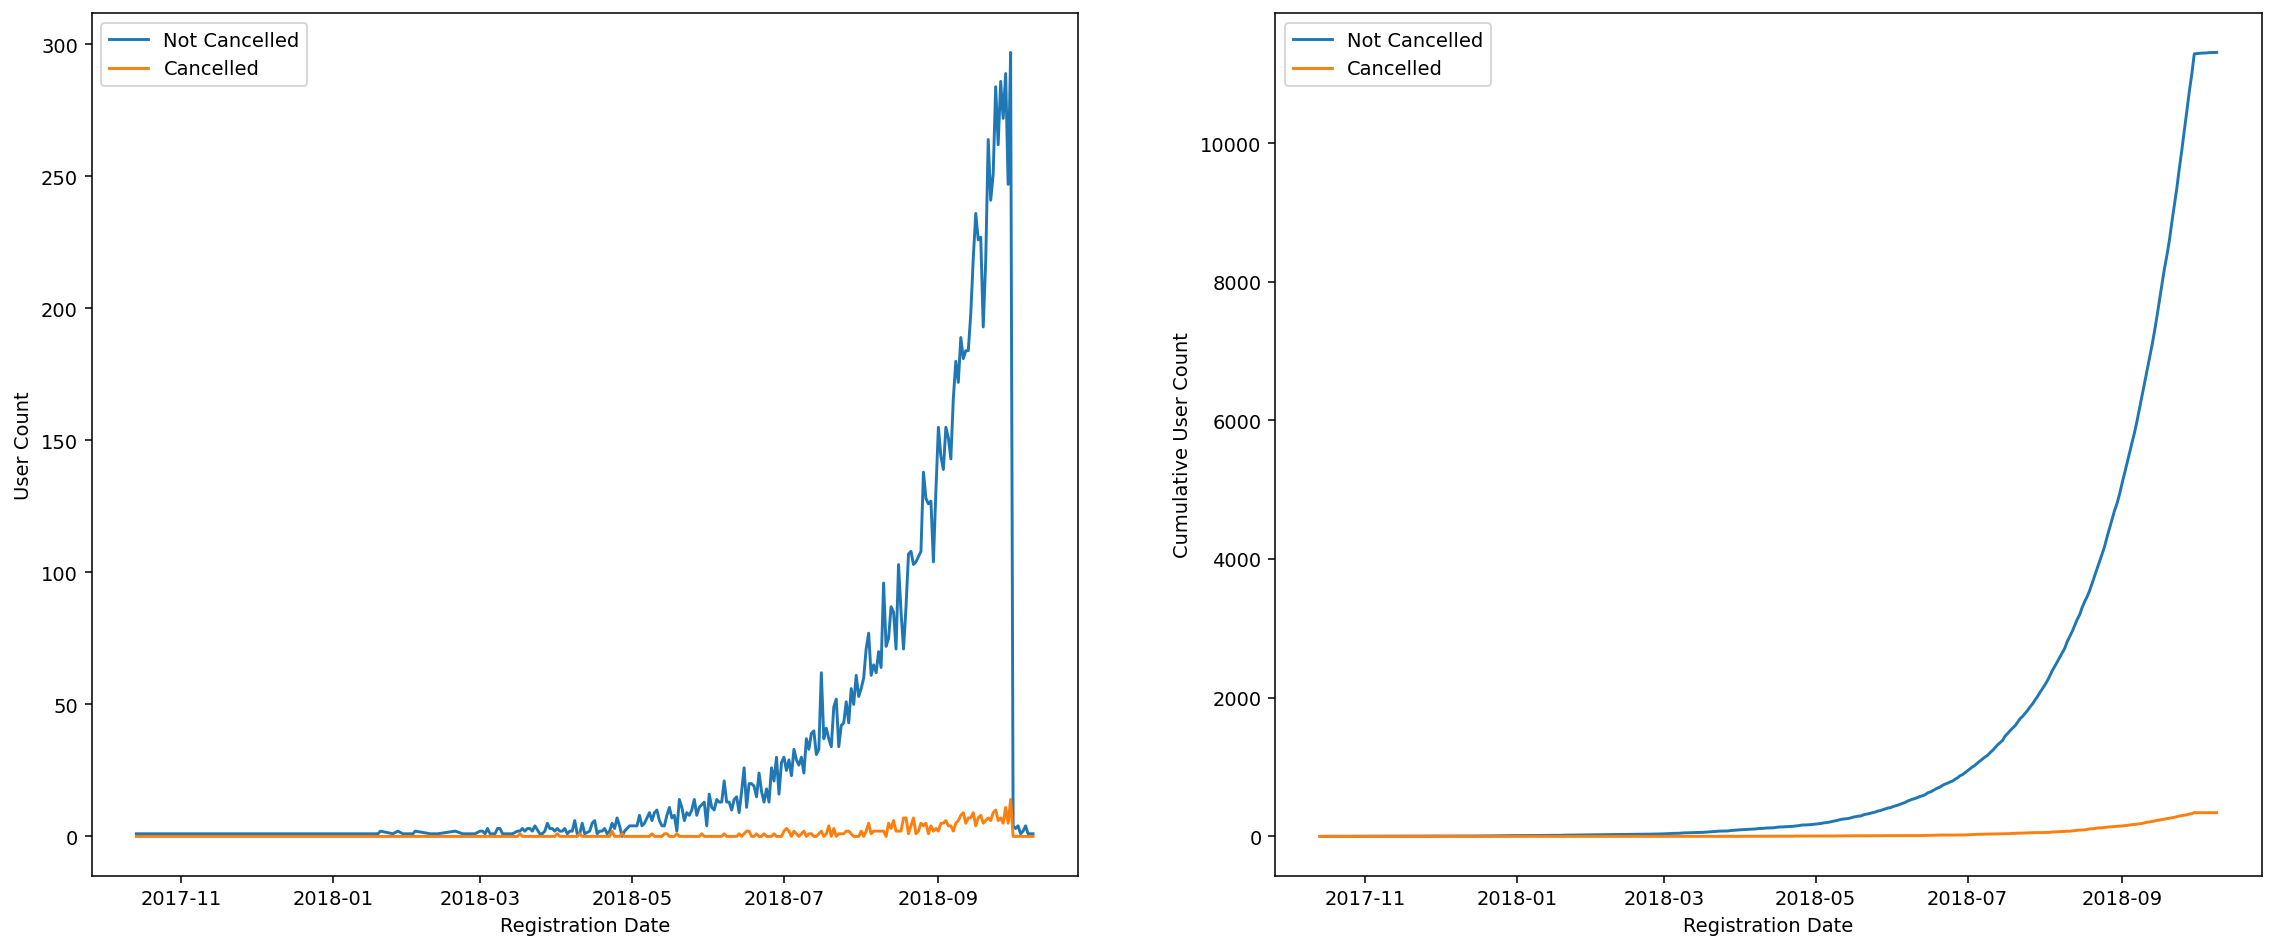

In [ ]:
fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

reg_df.plot(ax=axes[0], xlabel="Registration Date", ylabel="User Count")
reg_df_cumsum.plot(ax=axes[1], xlabel="Registration Date", ylabel="Cumulative User Count")

In [ ]:
# Last Activity date
last_activity_date = spark.sql("""
SELECT ts, label, COUNT(userIdIndex) AS count FROM
(
    SELECT events.userIdIndex, events.ts, churn.label FROM
    (
        SELECT userIdIndex, MAX(date(timestamp)) AS ts FROM sparkify_events
        GROUP BY userIdIndex
    ) AS events
    INNER JOIN churn ON events.userIdIndex = churn.userIdIndex
)
GROUP BY ts, label
""")

In [ ]:
lad_df = last_activity_date.toPandas()
lad_df = lad_df.pivot(index="ts", columns="label").fillna(0)
lad_df.columns = ["Not Cancelled", "Cancelled"]
lad_df_cumsum = lad_df.cumsum()

<Axes: xlabel='Last Activity Date', ylabel='Cumulative User Count'>

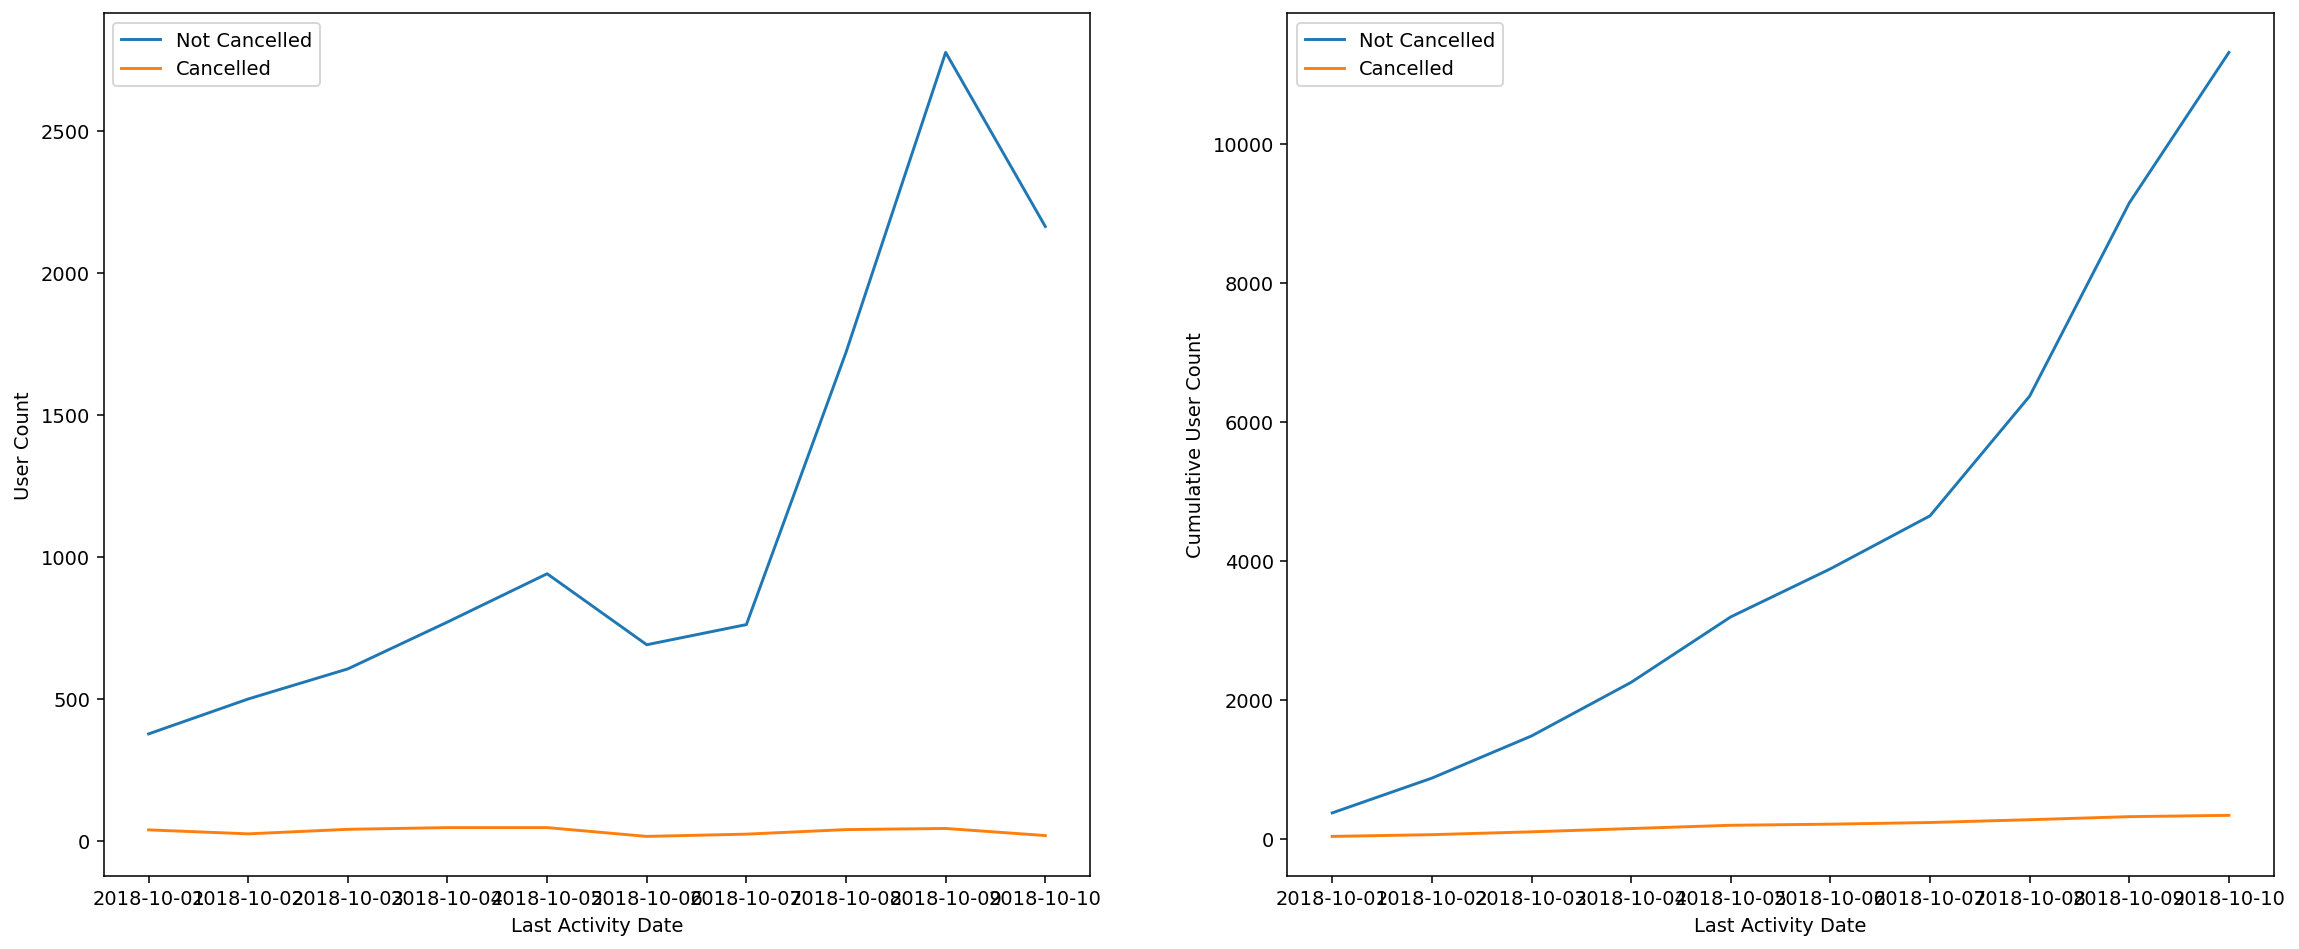

In [ ]:
fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

lad_df.plot(ax=axes[0], xlabel="Last Activity Date", ylabel="User Count")
lad_df_cumsum.plot(ax=axes[1], xlabel="Last Activity Date", ylabel="Cumulative User Count")

In [ ]:
# Mean User Age Date by Activity Date
mean_user_age = spark.sql("""
SELECT ts, label, COUNT(userIdIndex) AS users, AVG(age) AS age FROM
(
    SELECT events.userIdIndex, events.ts, events.age, churn.label FROM
    (
        SELECT userIdIndex, date(timestamp) AS ts, AVG(elapsed_days) AS age FROM sparkify_events
        GROUP BY userIdIndex, date(timestamp)
    ) AS events
    INNER JOIN churn ON events.userIdIndex = churn.userIdIndex
)
GROUP BY ts, label
""")

In [ ]:
mean_user_age_df = mean_user_age.toPandas()

mua_df = mean_user_age_df.pivot(index="ts", columns="label", values="age").fillna(0)
mua_df.columns = ["Not Cancelled", "Cancelled"]

user_count_df = mean_user_age_df.pivot(index="ts", columns="label", values="users").fillna(0)
user_count_df.columns = ["Not Cancelled", "Cancelled"]

<Axes: xlabel='Activity Date', ylabel='User Count'>

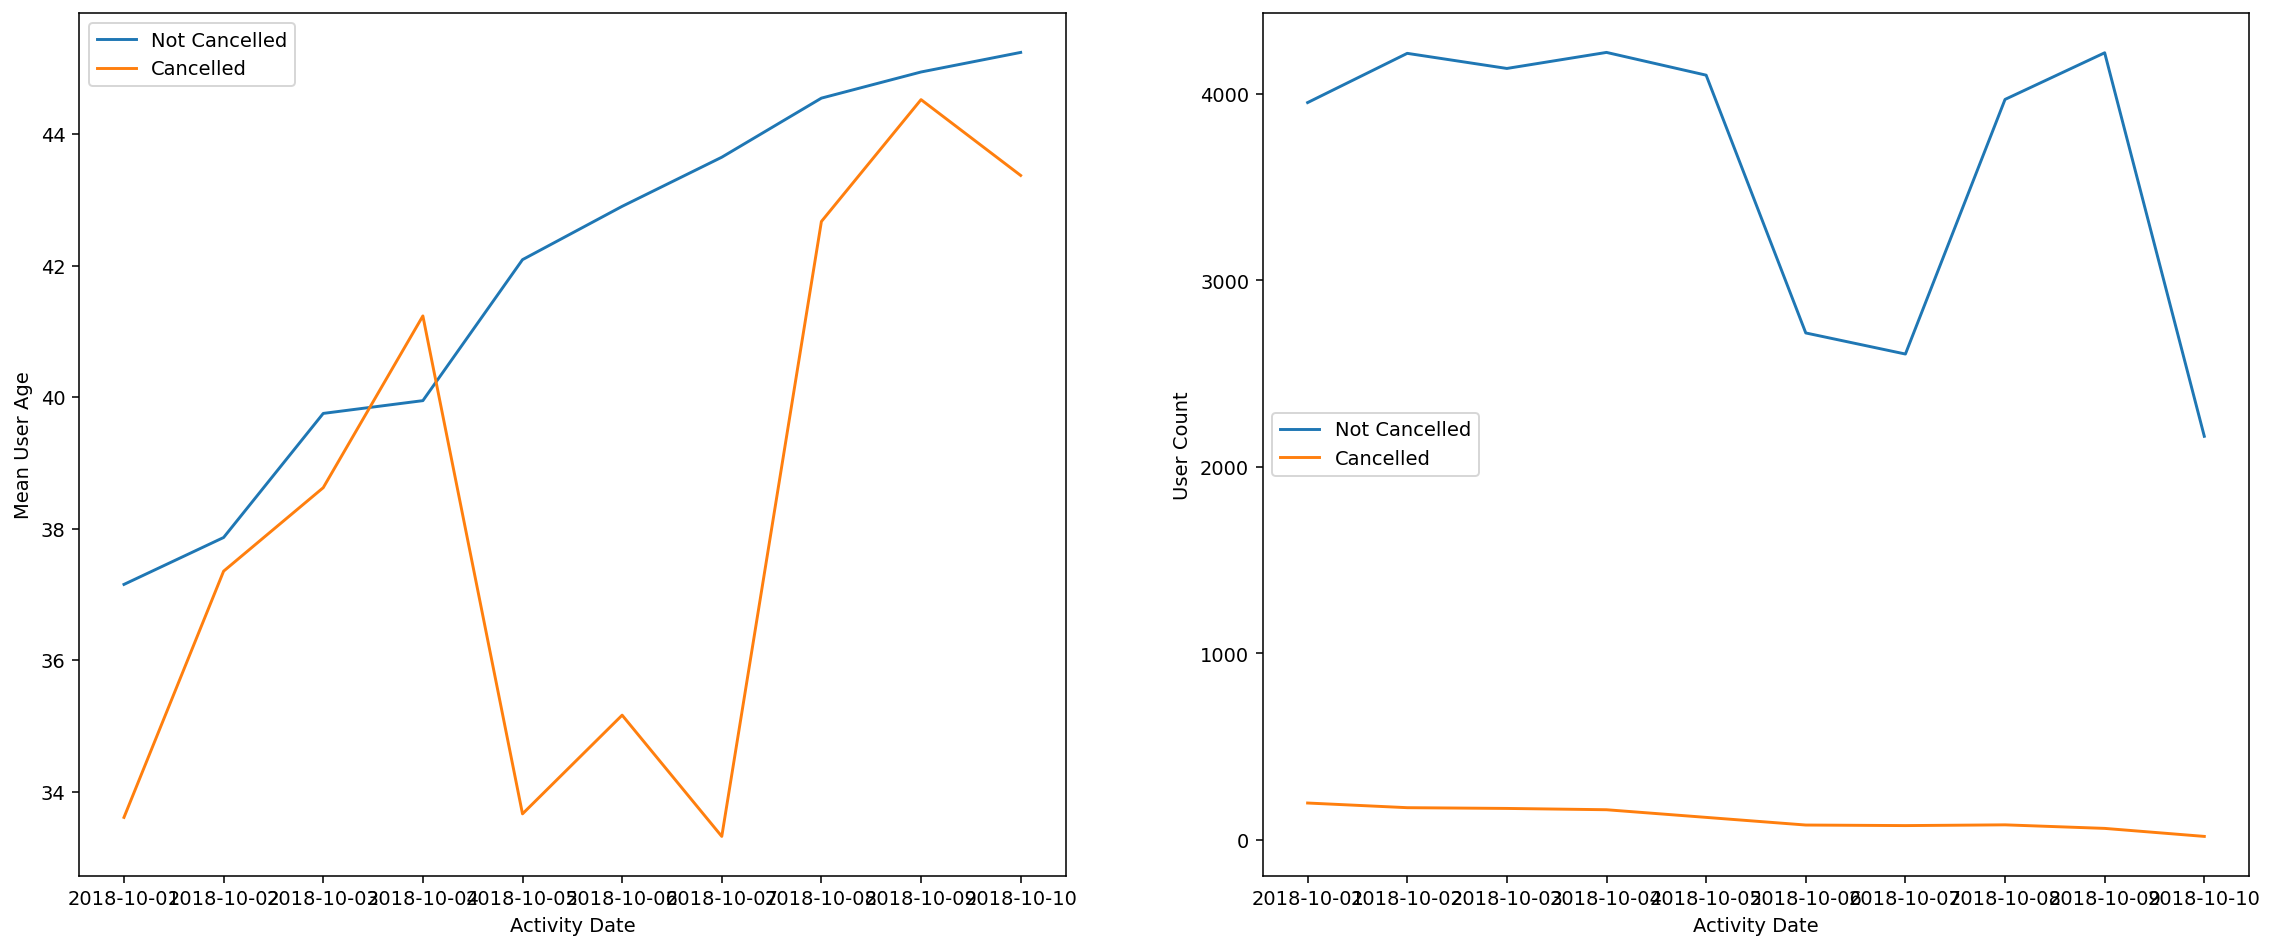

In [ ]:
fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

mua_df.plot(ax=axes[0], xlabel="Activity Date", ylabel="Mean User Age")
user_count_df.plot(ax=axes[1], xlabel="Activity Date", ylabel="User Count")

In [ ]:
# Sessions behavior
sessions = spark.sql("""
SELECT activity_time, label,
       COUNT(sessionId) AS sessions,
       AVG(interactions) AS interactions,
       AVG(session_time) AS session_time
FROM
(
    SELECT events.userIdIndex, events.interactions, events.sessionId, events.session_time, events.activity_time, churn.label FROM
    (
        SELECT userIdIndex, sessionId, COUNT(sessionId) AS interactions, MIN(elapsed_days) AS activity_time, (MAX(ts) - MIN(ts))/1000 AS session_time
        FROM sparkify_events
        GROUP BY userIdIndex, sessionId
    ) AS events
    INNER JOIN churn
    ON events.userIdIndex = churn.userIdIndex
)
GROUP BY activity_time, label
ORDER BY activity_time, label
""")

In [ ]:
sessions_df = sessions.toPandas()
sessions_df = sessions_df.pivot(index="activity_time", columns="label").fillna(0)

<Axes: title={'center': 'Mean Session Time per Activity Day'}, xlabel='Activity Day', ylabel='Mean Session Time (s)'>

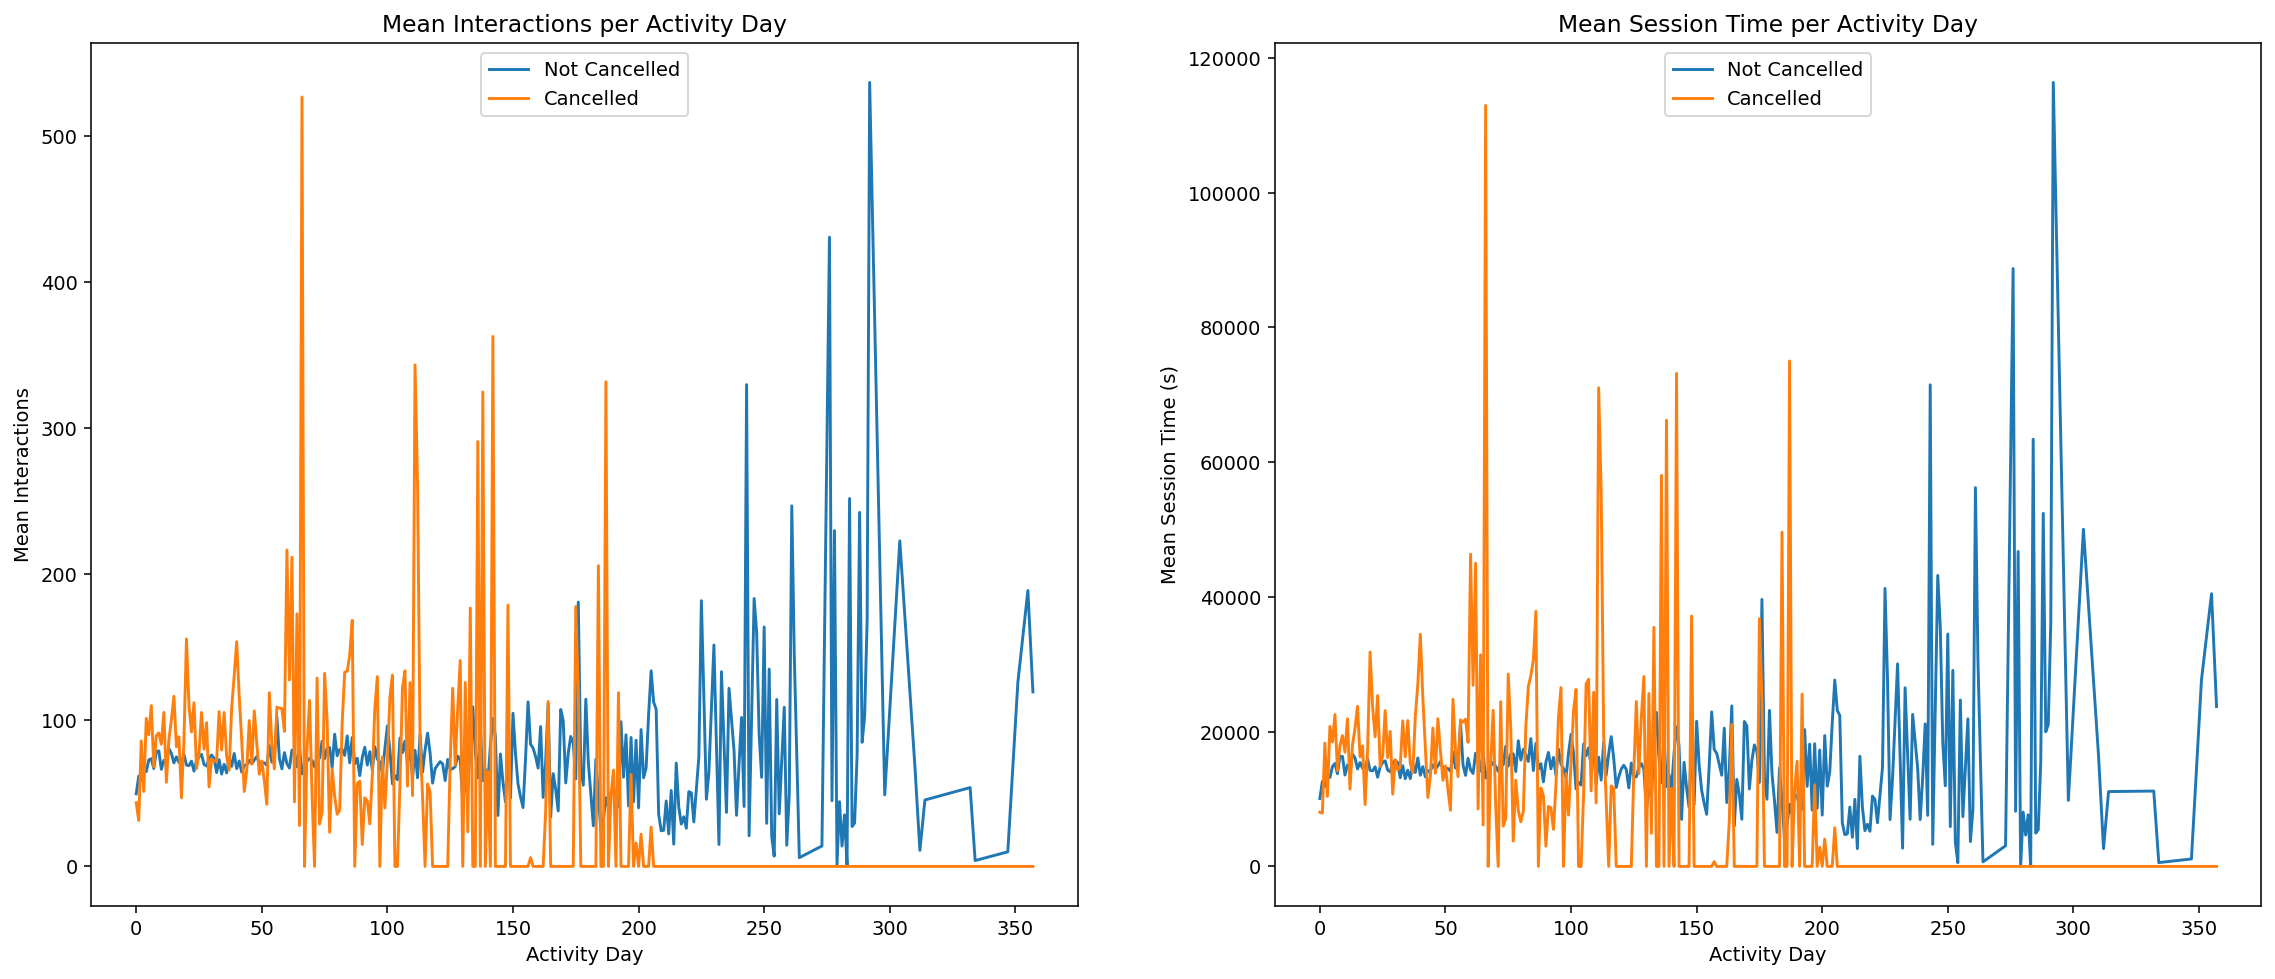

In [ ]:
si_df = sessions_df["interactions"].fillna(0)
si_df.columns = ["Not Cancelled", "Cancelled"]

sst_df = sessions_df["session_time"].fillna(0)
sst_df.columns = ["Not Cancelled", "Cancelled"]

fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

si_df.plot(ax=axes[0], xlabel="Activity Day", ylabel="Mean Interactions", title="Mean Interactions per Activity Day")
sst_df.plot(ax=axes[1], xlabel="Activity Day", ylabel="Mean Session Time (s)", title="Mean Session Time per Activity Day")

# Feature Engineering

1. **Latent Variables from ALS (Artists):**
   - **Features:** 20 latent variables from ALS.
   - **Source:** Derived from artists data.
   - **Purpose:** Capturing user preferences and relationships with artists.

2. **Percent of User Interaction with Pages:**
   - **Features:** 17 features representing the percentage of user interactions with each page.
   - **Source:** Derived from user page interaction data.
   - **Purpose:** Reflecting user engagement patterns with different pages.

3. **Count of Page Interaction:**
   - **Features:** 17 features representing the count of interactions for each page.
   - **Source:** Derived from user page interaction data.
   - **Purpose:** Quantifying the frequency of user interactions with different pages.

4. **User Level (Free or Paid):**
   - **Features:** 1 binary feature representing the user level (free or paid).
   - **Source:** Derived from user-level data.
   - **Purpose:** Differentiating between free and paid users.

5. **Percent of Events with a Paid Level:**
   - **Features:** 1 feature representing the percentage of events with a paid level for each user.
   - **Source:** Derived from user-level data.
   - **Purpose:** Indicating the extent of user engagement with paid levels.

6. **Gender:**
   - **Features:** 1 binary feature representing gender.
   - **Source:** Derived from user-level data.
   - **Purpose:** Incorporating gender information into the model.

7. **Song Length Mean and Stdev:**
   - **Features:** 2 features representing the mean and standard deviation of song lengths.
   - **Source:** Derived from song length data.
   - **Purpose:** Describing the distribution of song lengths.

8. **Hourly Song Count:**
   - **Features:** 24 features representing hourly song counts.
   - **Source:** Derived from timestamped song interaction data.
   - **Purpose:** Capturing variations in song listening patterns throughout the day.

9. **Hourly Song Mean Length:**
   - **Features:** 24 features representing hourly mean song lengths.
   - **Source:** Derived from timestamped song interaction and length data.
   - **Purpose:** Describing variations in average song length throughout the day.

10. **Age and Average Age of a User:**
    - **Features:** 2 features representing age and average age of a user.
    - **Source:** Derived from user-level data.
    - **Purpose:** Incorporating age-related information into the model.

11. **Aggregated User Sessions:**
    - **Features:** 9 features representing session count, average and stdev of page interactions, unique artist count, mean song length, and session time.
    - **Source:** Derived from user session data.
    - **Purpose:** Summarizing user session characteristics.


**Basic Idea:**

To build a model, we want to organize our data in a way that each row represents a user, and each column represents a specific feature or characteristic of that user. This organized data frame makes it easier for a machine learning model to understand and learn patterns.

For example, if we have information about users such as their age, gender, the number of songs they listen to, and the type of pages they visit, we would arrange this information in a table where each row corresponds to a unique user, and columns represent different aspects like age, gender, song count, etc.

This tabular structure allows us to train a machine learning model to recognize patterns and relationships between different features and predict whether a user is likely to churn or not based on their behavior.




In [ ]:
"""
The main function of this is to add a specified prefix to each column name, excluding the "userIdIndex" column. The modified DataFrame is then returned. This function can be useful for maintaining clarity and avoiding naming conflicts when working with multiple DataFrames or performing join operations.
"""
# Must have userIdIndex
def prefix_column(dataframe, prefix):
    cols = dataframe.columns.copy()
    cols.remove("userIdIndex")

    for col in cols:
        dataframe = dataframe.withColumnRenamed(col, f"{prefix}_{col}")

    return dataframe

Creating Features for the artist. The rating is determined by the number of songs played for that artist divided by the maximum count of songs played for any artist by that user.

##Note: We have removed ALS as a feature for model input as GCP was not able to run it for higher dataset like for 500k and above. The free version and machine configuration for Node 2 and 3 failed to process the ALS and have to be dropped from feature vector.

In [1]:
# def create_ratings(table_name):
#     """Create a ratings dataframe for a given table with events

#     Args:
#         table_name (str): The name of SQL table
#     """
#     rating_df = spark.sql(f"""
#     SELECT userIdIndex, artistIndex, COUNT(song) / MAX(COUNT(song)) OVER(PARTITION BY userIdIndex) AS rating
#     FROM {table_name}
#     WHERE artist IS NOT NULL
#     GROUP BY userIdIndex, artistIndex
#     """)

#     rating_df.createOrReplaceTempView(f"{table_name}_rating")

# # Create ratings for both total and last week events
# create_ratings("sparkify_events")
# create_ratings("last_week_events")

In [ ]:
# # Getting  user-artist ratings for the entire dataset.
# rating_df = spark.sql("SELECT * FROM sparkify_events_rating")
# rating_df
# rating_df.show()

The model object will contain the learned latent factors for users and artists.

- **Rank:** The rank determines the number of latent factors, which are underlying features or characteristics that the model learns from the user-item interactions.

- **RegParam:** It is a parameter that controls the amount of regularization applied to the model. A value of 0.01 indicates that the model aims to find a balance between fitting the training data well and preventing overfitting.

- **UserCol:** Represents the users that provided the ratings.

- **ItemCol:** Represents the items (artists), and the model will learn latent factors for each artist based on user interactions.

- **RatingCol:** Represents the ratings given by users to items (artists).

- **ColdStartStrategy:** The coldStartStrategy parameter handles the issue of "cold starts" for new users or items that were not present in the training data. Setting it to "drop" means that if the model encounters new users or items during the prediction phase, it will drop those rows from the DataFrame of predictions if they contain NaN values. This strategy avoids making predictions for entities that the model hasn't seen during training.

This model can be used to make predictions for user-item pairs and generate personalized recommendations based on the learned latent factors for users and items.


In [ ]:

# # Create ALS model and train (Reduce to 20 features)

# """
# ALS is used to create a recommendation model for artists based on user interactions. It's applied to the user-artist interaction matrix, and the resulting model can be used to predict ratings for artists that a user may not have interacted with, enabling personalized recommendations.
# """
# als = ALS(rank=20,
#           regParam=0.01,
#           userCol="userIdIndex",
#           itemCol="artistIndex",
#           ratingCol="rating",
#           coldStartStrategy="drop")

# model = als.fit(rating_df)

## Get ALS Features

Now we will be extracting features using ALS (Alternating Least Squares) model factors.

### Explanation:
- The ALS model is trained to learn latent factors for users and artists based on user-item interactions.
- The factors matrix is obtained from the model, representing the relationships between users and artists.
- The provided function `get_als_features` takes user-artist ratings, performs matrix multiplication, and generates features for each user.
- Two sets of features are created: one for all events (`als_features_all`) and another for events in the last week (`als_features_lw`) which is last week.

### Process:
1. **Matrix Multiplication:** The `get_als_features` function performs matrix multiplication between the user-artist ratings matrix and the item factor matrix.
2. **DataFrame Transformation:** The resulting array is transformed into separate columns, and a DataFrame is created with 'userIdIndex' and ALS features.
3. **Data Aggregation:** Two sets of features are generated for all events and last week events using the ALS model.

### Usage:
The ALS features can be utilized as input features in the model training process for predicting user engagement or preferences.


In [ ]:
# # Get item factors matrix from ALS model
# factors = IndexedRowMatrix(model.itemFactors.rdd.map(tuple)).toBlockMatrix().toLocalMatrix()

# def get_als_features(ratings, factors, num_factors=20, output_col="vector"):
#     """Get features for each user given the ratings dataframe and the item factor matrix.

#     Args:
#         ratings (object): A Spark Dataframe with the columns userIdIndex, artistIndex and rating
#         factors (IndexedRowMatrix): A Matrix with Item Factors from a trained ALS model
#         output_col (str): The name of the output column features

#     Returns:
#         object: A Spark Dataframe with columns userIdIndex and several output_col in the number of number
#         of factors

#     """
#     mat = CoordinateMatrix(ratings.select("userIdIndex", "artistIndex", "rating").rdd.map(tuple))
#     mat = mat.toIndexedRowMatrix()

#     # Dot multiplication between user-artist ratings matrix and artist factors
#     dataframe = mat.multiply(factors).rows.toDF()

#     # Transform array to columns
#     dataframe = dataframe.withColumn("userIdIndex", dataframe["index"].cast(DoubleType()))
#     dataframe = dataframe.withColumn(output_col, vector_to_array("vector"))
#     dataframe = dataframe.select(["userIdIndex"] + [dataframe[output_col][i] for i in range(num_factors)])

#     return dataframe


# # All events
# als_features_all = get_als_features(rating_df, factors, output_col="als_features_all")

# # Last week events
# rating_last_week_df = spark.sql("""
#     SELECT t.userIdIndex, t.artistIndex, IFNULL(lw.rating, 0) AS rating FROM sparkify_events_rating AS t
#     LEFT JOIN last_week_events_rating AS lw
#     ON t.userIdIndex = lw.userIdIndex AND t.artistIndex = lw.artistIndex
# """)
# als_features_lw = get_als_features(rating_last_week_df, factors, output_col="als_features_lw")

In [ ]:
# als_features_lw.show()

In [ ]:
# als_features_all.show()

In [ ]:
# als_features_all

In [ ]:
# als_features_lw

## Percentage of Access for Each Page for Each User

The `create_page_percentage` function is designed to calculate the percentage of interaction with specific pages for each user over all page interactions. It removes pages related to churn prediction, such as 'Cancel' and 'Cancellation Confirmation,' as they are used for prediction, not as features.

### Function Explanation:
- **Input:** The function takes a Spark SQL table name as input.
- **Process:** It selects the userIdIndex, page, and calculates the percentage of each page interaction over all pages for each user, excluding 'Cancel' and 'Cancellation Confirmation' pages.
- **Output:** The result is a Spark DataFrame containing userIdIndex, page, and the calculated page percentage.

### Usage:
- Two instances of the function are used for:
  - **All Events:** Calculating the percentage of access for each page for all events in the `sparkify_events` table. The result is stored in the `page_pct_all` DataFrame.
  - **Last Week Events:** Calculating the same percentages for the last week's events in the `last_week_events` table. The result is stored in the `page_pct_lw` DataFrame.

### Result:
- Both DataFrames (`page_pct_all` and `page_pct_lw`) are structured with userIdIndex as the key and different pages as columns, storing the corresponding page percentages.


In [ ]:
## Percentage of access for each page for each user
# Remove Cancel and Cancellation Confirmation
def create_page_percentage(table_name):
    page_df = spark.sql(f"""
    SELECT userIdIndex, page, COUNT(page) / SUM(COUNT(page)) OVER(PARTITION BY userIdIndex) AS page_perct
    FROM {table_name}
    WHERE page IS NOT NULL AND page != 'Cancel' AND page != 'Cancellation Confirmation'
    GROUP BY userIdIndex, page
    """)

    return page_df

# All events
page_pct_all = create_page_percentage("sparkify_events").groupBy("userIdIndex").pivot("page").sum("page_perct").na.fill(0.)
page_pct_all = prefix_column(page_pct_all, prefix="page_pct_all")

# Last week events
page_pct_lw = create_page_percentage("last_week_events").groupBy("userIdIndex").pivot("page").sum("page_perct").na.fill(0.)
page_pct_lw = prefix_column(page_pct_lw, prefix="page_pct_lw")

## Total Page Access

The `create_page_counts` function is designed to calculate the total number of page accesses for each user. It excludes pages related to churn prediction, such as 'Cancel' and 'Cancellation Confirmation,' as they are used for prediction, not as features.

### Function Explanation:
- **Input:** The function takes a Spark SQL table name as input.
- **Process:** It selects the userIdIndex, page, and calculates the count of each page access for each user, excluding 'Cancel' and 'Cancellation Confirmation' pages.
- **Output:** The result is a Spark DataFrame containing userIdIndex, page, and the corresponding page access count.

### Usage:
- Two instances of the function are used for:
  - **All Events:** Calculating the total page access count for all events in the `sparkify_events` table. The result is stored in the `page_count_all` DataFrame.
  - **Last Week Events:** Calculating the total page access count for the last week's events in the `last_week_events` table. The result is stored in the `page_count_lw` DataFrame.

### Result:
- Both DataFrames (`page_count_all` and `page_count_lw`) are structured with userIdIndex as the key and different pages as columns, storing the corresponding total page access counts.


In [ ]:
# Total page access
def create_page_counts(table_name):
    page_df = spark.sql(f"""
    SELECT userIdIndex, page, COUNT(page) AS page_count
    FROM {table_name}
    WHERE page IS NOT NULL AND page != 'Cancel' AND page != 'Cancellation Confirmation'
    GROUP BY userIdIndex, page
    """)

    return page_df

# All events
page_count_all = create_page_counts("sparkify_events").groupby("userIdIndex").pivot("page").sum("page_count").na.fill(0)
page_count_all = prefix_column(page_count_all, prefix="page_count_all")

# Last week events
page_count_lw = create_page_counts("last_week_events").groupby("userIdIndex").pivot("page").sum("page_count").na.fill(0)
page_count_lw = prefix_column(page_count_lw, prefix="page_count_lw")

In [ ]:
page_count_all.show()

+-----------+--------------------+-------------------------+------------------------------+------------------------+--------------------+-------------------+-------------------+---------------------+-----------------------+--------------------------+----------------------------+-----------------------+-------------------------------+-----------------------------+--------------------------+------------------------+----------------------+
|userIdIndex|page_count_all_About|page_count_all_Add Friend|page_count_all_Add to Playlist|page_count_all_Downgrade|page_count_all_Error|page_count_all_Help|page_count_all_Home|page_count_all_Logout|page_count_all_NextSong|page_count_all_Roll Advert|page_count_all_Save Settings|page_count_all_Settings|page_count_all_Submit Downgrade|page_count_all_Submit Upgrade|page_count_all_Thumbs Down|page_count_all_Thumbs Up|page_count_all_Upgrade|
+-----------+--------------------+-------------------------+------------------------------+------------------------+--

## Level Percentage

The `create_level_percentage` function is designed to calculate the percentage of events in each user level, considering the number of events that occurred in each level. It excludes the 'free' level, as it is linearly dependent on the 'paid' level, resulting in high correlation.

### Function Explanation:
- **Input:** The function takes a Spark SQL table name as input.
- **Process:** It selects the userIdIndex, level, and calculates the percentage of events for each user in each level, excluding 'free' level events.
- **Output:** The result is a Spark DataFrame containing userIdIndex, level, and the corresponding level percentage.

### Usage:
- Two instances of the function are used for:
  - **All Events:** Calculating the level percentage for all events in the `sparkify_events` table. The result is stored in the `level_pct_all` DataFrame.
  - **Last Week Events:** Calculating the level percentage for the last week's events in the `last_week_events` table. The result is stored in the `level_pct_lw` DataFrame.

### Result:
- Both DataFrames (`level_pct_all` and `level_pct_lw`) are structured with userIdIndex as the key and different levels as columns, storing the corresponding level percentages.


In [ ]:
# Level percentage
# Drop free (because paid = 1 - free, no necessity to have both as they are linearly dependent, thus highly correlated)
def create_level_percentage(table_name):
    level_df = spark.sql(f"""
    SELECT userIdIndex, level, COUNT(level) / SUM(COUNT(level)) OVER(PARTITION BY userIdIndex) AS level_perct
    FROM {table_name}
    WHERE level IS NOT NULL
    GROUP BY userIdIndex, level
    """)

    return level_df

# All events
level_pct_all = create_level_percentage("sparkify_events").groupBy("userIdIndex").pivot("level").sum("level_perct").na.fill(0.).drop("free")
level_pct_all = prefix_column(level_pct_all, prefix="level_pct_all")

# Last week events
level_pct_lw = create_level_percentage("last_week_events").groupBy("userIdIndex").pivot("level").sum("level_perct").na.fill(0.).drop("free")
level_pct_lw = prefix_column(level_pct_lw, prefix="level_pct_lw")

In [ ]:
level_pct_all.show()

+-----------+--------------------+
|userIdIndex|  level_pct_all_paid|
+-----------+--------------------+
|    11028.0|                 0.0|
|     6067.0|                 1.0|
|     8649.0|                 0.0|
|      692.0|  0.9185360094451004|
|     6765.0|                 0.0|
|     1761.0|  0.7741935483870968|
|     5858.0|                 0.0|
|     3901.0|                 0.0|
|    10129.0|                 0.0|
|     9753.0|                 0.0|
|     9923.0|                 0.0|
|    10930.0|                 0.0|
|     7782.0|                 0.0|
|     3980.0|  0.6211453744493393|
|      305.0|  0.8950988822012038|
|    10625.0|                 1.0|
|    10924.0|                 1.0|
|     4800.0|0.055865921787709494|
|      558.0|                 1.0|
|     2734.0|  0.5523255813953488|
+-----------+--------------------+
only showing top 20 rows



## Gender Encoding

 So here performs one-hot encoding for the "gender" column. It first indexes the gender values numerically and then applies one-hot encoding to represent gender information as binary vectors. The resulting DataFrame (gender) contains the original "userIdIndex" along with the one-hot encoded "gender" column.

### Explanation:
- The `StringIndexer` is utilized to convert the categorical 'gender' column into numerical values, creating a new column named 'genderIndex.'
- The `OneHotEncoder` is then applied to the 'genderIndex' column, transforming it into a sparse vector representation in a new column named 'g.'
- The final result is a DataFrame named 'gender,' containing the 'userIdIndex' and the one-hot encoded 'gender' column.

### Process:
1. **Initial Aggregation:** The 'gender' DataFrame is initially aggregated by selecting the first occurrence of 'gender' for each 'userIdIndex.'
2. **Indexing:** The 'StringIndexer' is applied to create a numerical representation of the 'gender' column, resulting in the 'genderIndex' column.
3. **One-Hot Encoding:** The 'OneHotEncoder' is used to convert the numerical 'genderIndex' into a sparse vector representation named 'g.'
4. **Column Selection:** The final 'gender' DataFrame is created by selecting the 'userIdIndex' and the 'g' column, which represents the one-hot encoded 'gender.'

### Usage:
The 'gender' DataFrame can be further utilized as a feature in the model training process.


In [ ]:
# Gender
gender_encoder = OneHotEncoder(inputCols=["genderIndex"], outputCols=["g"])
gender_indexer = StringIndexer(inputCol="gender", outputCol="genderIndex")

gender = df.groupBy("userIdIndex").agg(F.first("gender").alias("gender"))
gender = gender_indexer.fit(gender).transform(gender)
gender = gender_encoder.fit(gender).transform(gender).select("userIdIndex", "g")
gender = gender.withColumnRenamed("g", "gender")

In [ ]:
gender.show()

+-----------+-------------+
|userIdIndex|       gender|
+-----------+-------------+
|        1.0|(1,[0],[1.0])|
|        2.0|(1,[0],[1.0])|
|        3.0|    (1,[],[])|
|        4.0|    (1,[],[])|
|        5.0|    (1,[],[])|
|        6.0|    (1,[],[])|
|        7.0|(1,[0],[1.0])|
|        8.0|(1,[0],[1.0])|
|        9.0|    (1,[],[])|
|       10.0|(1,[0],[1.0])|
|       11.0|(1,[0],[1.0])|
|       12.0|(1,[0],[1.0])|
|       13.0|(1,[0],[1.0])|
|       14.0|(1,[0],[1.0])|
|       15.0|    (1,[],[])|
|       16.0|(1,[0],[1.0])|
|       17.0|    (1,[],[])|
|       18.0|    (1,[],[])|
|       19.0|    (1,[],[])|
|       20.0|(1,[0],[1.0])|
+-----------+-------------+
only showing top 20 rows



# Song Length Features

It calculates statistical features related to song length for each user, creating two sets of features: one for all events (`song_length_all`) and another for events in the last week (`song_length_lw`). Calculating the mean and standard deviation of song lengths for all events and last week events separately allows for capturing both overall listening behavior and recent trends. These summary statistics can be part of a broader feature set used in machine learning models to predict user behavior, such as churn prediction or personalized recommendations.

### Explanation:
- The `mean` and `stddev` of the song length are calculated for each user, representing the average and standard deviation of song durations.
- Two DataFrames are created, aggregating these statistics for all events and events in the last week.
- The resulting DataFrames contain columns prefixed with "song_length_all" and "song_length_lw," respectively.

### Process:
1. **Grouping by User:** The original DataFrame is grouped by 'userIdIndex.'
2. **Statistical Aggregation:** The mean and standard deviation of song length are calculated for each user.
3. **Data Imputation:** Null values resulting from the aggregation are filled with zeros.
4. **Column Prefixing:** The columns are prefixed with "song_length_all" and "song_length_lw" for the two sets of features.

### Usage:
The generated features can be utilized to understand user preferences or patterns related to song lengths in the model training process.


In [ ]:
# Song length
song_length_all = df.groupBy("userIdIndex").agg(F.mean("length").alias("mean"), F.stddev("length").alias("std")).na.fill(0.)
song_length_all = prefix_column(song_length_all, prefix="song_length_all")

song_length_lw = last_week_df.groupBy("userIdIndex").agg(F.mean("length").alias("mean"), F.stddev("length").alias("std")).na.fill(0.)
song_length_lw = prefix_column(song_length_lw, prefix="song_length_lw")

In [ ]:
song_length_all.show()

+-----------+--------------------+-------------------+
|userIdIndex|song_length_all_mean|song_length_all_std|
+-----------+--------------------+-------------------+
|     4066.0|  248.54711917647052|  99.93020998586911|
|     8649.0|  257.24203717948706|  89.12940292116161|
|     5360.0|  256.23710444444436|  86.58246048674386|
|      769.0|   247.7445764350451|  85.71574371930966|
|     3901.0|  249.23676747191013|  98.93472023943674|
|     7171.0|   252.2281665671643|  84.30582280440848|
|     5983.0|  238.58002920454555|  71.99116184143375|
|     6454.0|  255.97342419354837|  88.94577680276466|
|    10129.0|   265.8919176923077| 132.15393083007035|
|      596.0|   247.5320005721717|  98.30503973245561|
|    10831.0|  206.74131666666668|   54.7171682451209|
|    11028.0|   326.8305666666667| 126.70014349020217|
|     9753.0|  288.08553333333333|   106.747308498627|
|      934.0|  251.37478467948722|  97.22867350323932|
|      720.0|  241.45637688500736|  88.44846729676294|
|    10633

# Hourly Song Counts Features

It calculates hourly song counts for each user, creating two sets of features: one for all events (`hourly_song_counts_all`) and another for events in the last week (`hourly_song_counts_lw`). Creating the hourly played songs and mean length for each of 24 hours.

### Explanation:
- Selects the "userIdIndex" column and extracts the hour component from the timestamp ("ts") in the "df" DataFrame. Creates a new column named "hour" with the extracted hour information.
- Groups the DataFrame by "userIdIndex" and "hour". Counts the number of songs for each user in each hour.
- Groups the data again by "userIdIndex". Pivots the "hour" column to create separate columns for each hour, and sums the song counts for each user in each hour. Missing values are filled with 0.
- Adds a prefix "hourly_song_counts_all" to the column names for clarity.

### Process:
1. **Timestamp Conversion:** The timestamp is converted to hours using the `from_unixtime` function.
2. **Grouping by User and Hour:** The DataFrame is grouped by 'userIdIndex' and 'hour.'
3. **Count Calculation:** The count of songs is calculated for each hour.
4. **Data Imputation:** Null values resulting from the aggregation are filled with zeros.
5. **Column Prefixing:** The columns are prefixed with "hourly_song_counts_all" and "hourly_song_counts_lw" for the two sets of features.

### Usage:
These features capture the hourly distribution of song counts and can be used to understand user listening patterns across different hours.


In [ ]:
# Hourly Song Counts
hourly_song_counts_all = df.select("userIdIndex", F.hour(F.from_unixtime(df.ts/1000)).alias("hour")).groupBy("userIdIndex", "hour").count().groupBy("userIdIndex").pivot("hour").sum("count").na.fill(0)
hourly_song_counts_all = prefix_column(hourly_song_counts_all, prefix="hourly_song_counts_all")

hourly_song_counts_lw = last_week_df.select("userIdIndex", F.hour(F.from_unixtime(df.ts/1000)).alias("hour")).groupBy("userIdIndex", "hour").count().groupBy("userIdIndex").pivot("hour").sum("count").na.fill(0)
hourly_song_counts_lw = prefix_column(hourly_song_counts_lw, prefix="hourly_song_counts_lw")

In [ ]:
hourly_song_counts_all.show()

+-----------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|userIdIndex|hourly_song_counts_all_0|hourly_song_counts_all_1|hourly_song_counts_all_2|hourly_song_counts_all_3|hourly_song_counts_all_4|hourly_song_counts_all_5|hourly_song_counts_all_6|hourly_song_counts_all_7|hourly_song_counts_all_8|hourly_song_counts_all_9|hourly_song_counts_all_10|hourly_song_counts_all_11|hourly_song_counts_all_12|hourly_song_counts_all_13|hourl

# Hourly Mean Song Length Features

It calculates the hourly mean song length for each user, creating two sets of features: one for all events (`hourly_mean_song_length_all`) and another for events in the last week (`hourly_mean_song_length_lw`).

### Explanation:
- Selects the "userIdIndex" column, the "length" column representing song lengths, and extracts the hour component from the timestamp ("ts") in the "df" DataFrame. creates a new column named "hour" with the extracted hour information.
- Groups the DataFrame by "userIdIndex" and "hour". Calculates the mean song length for each user in each hour.
- Groups the data again by "userIdIndex". Pivots the "hour" column to create separate columns for each hour, and calculates the mean song length for each user in each hour. Missing values are filled with 0.
- Adds a prefix "hourly_mean_song_length_all" to the column names for clarity.

### Process:
1. **Timestamp Conversion:** The timestamp is converted to hours using the `from_unixtime` function.
2. **Grouping by User, Hour, and Length:** The DataFrame is grouped by 'userIdIndex,' 'hour,' and 'length.'
3. **Mean Calculation:** The mean song length is calculated for each hour.
4. **Data Imputation:** Null values resulting from the aggregation are filled with zeros.
5. **Column Prefixing:** The columns are prefixed with "hourly_mean_song_length_all" and "hourly_mean_song_length_lw" for the two sets of features.

### Usage:
These features capture the hourly distribution of mean song lengths and can be used to understand user preferences regarding song durations throughout the day.


In [ ]:
# Hourly Mean Song Length
hourly_mean_song_length_all = df.select("userIdIndex", "length", F.hour(F.from_unixtime(df.ts/1000)).alias("hour")).groupBy("userIdIndex", "hour").mean("length").groupBy("userIdIndex").pivot("hour").mean("avg(length)").na.fill(0)
hourly_mean_song_length_all = prefix_column(hourly_mean_song_length_all, prefix="hourly_mean_song_length_all")

hourly_mean_song_length_lw = last_week_df.select("userIdIndex", "length", F.hour(F.from_unixtime(df.ts/1000)).alias("hour")).groupBy("userIdIndex", "hour").mean("length").groupBy("userIdIndex").pivot("hour").mean("avg(length)").na.fill(0)
hourly_mean_song_length_lw = prefix_column(hourly_mean_song_length_lw, prefix="hourly_mean_song_length_lw")

In [ ]:
hourly_mean_song_length_all.show()

+-----------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|userIdIndex|hourly_mean_song_length_all_0|hourly_mean_song_length_all_1|hourly_mean_song_length_all_2|hourly_mean_song_length_all_3|hourly_mean_song_length_all_4|hourly_mean_song_length_all_5|hourly_mean_song_length_all_6|hourly_mean_song_length_all_7

In [ ]:
# Calculates the maximum and average elapsed days since user registration, creating a DataFrame named `elapsed_days`.
elapsed_days = spark.sql("""
    SELECT userIdIndex, MAX(elapsed_days) AS age, AVG(elapsed_days) AS avg_age
    FROM sparkify_events
    GROUP BY userIdIndex
""")

In [ ]:
elapsed_days.show()

+-----------+---+------------------+
|userIdIndex|age|           avg_age|
+-----------+---+------------------+
|     4066.0| 11| 7.009049773755656|
|     8649.0| 13|              13.0|
|     5360.0| 13| 9.679738562091503|
|      769.0|184|179.92919254658386|
|     3901.0| 27|22.566523605150216|
|     7171.0| 19| 12.75294117647059|
|     5983.0| 71|              71.0|
|     6454.0| 11| 8.925925925925926|
|    10129.0| 44| 42.47826086956522|
|      596.0| 21|16.397365532381997|
|    10831.0| 14|10.666666666666666|
|    11028.0| 36|              36.0|
|     9753.0|  9|               9.0|
|      720.0| 13| 10.41656662665066|
|    10633.0| 14|              14.0|
|    11369.0| 42|              42.0|
|     5642.0| 33|31.100719424460433|
|     3432.0| 13|11.143382352941176|
|     2523.0| 35|29.514745308310992|
|     3507.0| 55| 54.33207547169811|
+-----------+---+------------------+
only showing top 20 rows



# User Sessions Aggregation

Now here we aggregates user session information, creating a DataFrame named `sessions`. Basically, created a DataFrame (sessions) that contains various session-related metrics for each user based on their activities recorded in the "sparkify_events" DataFrame. These metrics can provide insights into user engagement and behavior during sessions.

### Explanation:
- The inner query calculates various session-related metrics such as the number of songs played, pages accessed, count of distinct artists, average song length, and session time for each user session.
- The outer query further aggregates these session metrics on the 'userIdIndex' level, computing statistics such as the total number of sessions, average pages accessed, average count of artists, average song length, average session time, and standard deviations for corresponding metrics.
- The resulting DataFrame, named `sessions`, contains aggregated session information for each user.

### Process:
1. **Inner Query:** Calculates session-level metrics by grouping data based on 'userIdIndex' and 'sessionId.'
    - Metrics include the count of songs played, pages accessed, distinct artists, average song length, and session time.
2. **Outer Query:** Further aggregates session metrics on the 'userIdIndex' level, calculating total session count, average pages accessed, average count of artists, average song length, average session time, and standard deviations for each metric.
3. **Handling Missing Values:** Any missing standard deviation values (NAs) are filled with 0 in the final DataFrame.

### Usage:
The `sessions` DataFrame provides a comprehensive summary of user sessions, capturing key metrics that can be used as features for predicting user behavior or analyzing engagement patterns.


In [ ]:
sessions = spark.sql("""
SELECT userIdIndex,
       COUNT(sessionId) AS sessions_count,
       AVG(pages_accessed) AS sessions_avg_pages_accessed,
       AVG(count_artists) AS sessions_avg_count_artists,
       AVG(avg_song_length) AS sessions_avg_song_length,
       AVG(session_time) AS sessions_avg_session_time,
       STD(pages_accessed) AS sessions_std_pages_accessed,
       STD(count_artists) AS sessions_std_count_artists,
       STD(avg_song_length) AS sessions_std_song_length,
       STD(session_time) AS sessions_std_session_time
FROM
(
    SELECT userIdIndex, sessionId, COUNT(song) AS songs_played, COUNT(page) AS pages_accessed,
           COUNT(DISTINCT artist) AS count_artists, AVG(length) AS avg_song_length,
           (MAX(ts) - MIN(ts)) / 1000 AS session_time
    FROM sparkify_events
    GROUP BY userIdIndex, sessionId
)
GROUP BY userIdIndex
""")
# Fill std NAs with 0
sessions = sessions.fillna(0.)

In [ ]:
sessions.show()

+-----------+--------------+---------------------------+--------------------------+------------------------+-------------------------+---------------------------+--------------------------+------------------------+-------------------------+
|userIdIndex|sessions_count|sessions_avg_pages_accessed|sessions_avg_count_artists|sessions_avg_song_length|sessions_avg_session_time|sessions_std_pages_accessed|sessions_std_count_artists|sessions_std_song_length|sessions_std_session_time|
+-----------+--------------+---------------------------+--------------------------+------------------------+-------------------------+---------------------------+--------------------------+------------------------+-------------------------+
|     2815.0|             7|                       48.0|        34.285714285714285|      233.08441285830108|        9035.857142857143|          64.37908563086825|         46.55718450004713|       19.90181084638272|       12806.057634684343|
|      769.0|             5|        

Combines all DataFrames into a single DataFrame (no_lw_features) by performing sequential joins based on the common column "userIdIndex." This don't have any last week feature data.

In [ ]:
#  The "churn" DataFrame based on the common column "userIdIndex."
no_lw_features = page_pct_all.join(page_count_all, on=["userIdIndex"])\
                   .join(level_pct_all, on=["userIdIndex"])\
                   .join(song_length_all, on=["userIdIndex"])\
                   .join(hourly_song_counts_all, on=["userIdIndex"])\
                   .join(hourly_mean_song_length_all, on=["userIdIndex"])\
                   .join(elapsed_days, on=["userIdIndex"])\
                   .join(sessions, on=["userIdIndex"])\
                   .join(churn, on=["userIdIndex"])

In [ ]:
print(len(no_lw_features.columns))

98


In [ ]:
no_lw_features.show()

+-----------+--------------------+-----------------------+----------------------------+----------------------+--------------------+--------------------+--------------------+--------------------+---------------------+------------------------+--------------------------+---------------------+-----------------------------+---------------------------+------------------------+----------------------+--------------------+--------------------+-------------------------+------------------------------+------------------------+--------------------+-------------------+-------------------+---------------------+-----------------------+--------------------------+----------------------------+-----------------------+-------------------------------+-----------------------------+--------------------------+------------------------+----------------------+------------------+--------------------+-------------------+------------------------+------------------------+------------------------+---------------------

In [ ]:
no_lw_features.printSchema()

root
 |-- userIdIndex: double (nullable = false)
 |-- page_pct_all_About: double (nullable = false)
 |-- page_pct_all_Add Friend: double (nullable = false)
 |-- page_pct_all_Add to Playlist: double (nullable = false)
 |-- page_pct_all_Downgrade: double (nullable = false)
 |-- page_pct_all_Error: double (nullable = false)
 |-- page_pct_all_Help: double (nullable = false)
 |-- page_pct_all_Home: double (nullable = false)
 |-- page_pct_all_Logout: double (nullable = false)
 |-- page_pct_all_NextSong: double (nullable = false)
 |-- page_pct_all_Roll Advert: double (nullable = false)
 |-- page_pct_all_Save Settings: double (nullable = false)
 |-- page_pct_all_Settings: double (nullable = false)
 |-- page_pct_all_Submit Downgrade: double (nullable = false)
 |-- page_pct_all_Submit Upgrade: double (nullable = false)
 |-- page_pct_all_Thumbs Down: double (nullable = false)
 |-- page_pct_all_Thumbs Up: double (nullable = false)
 |-- page_pct_all_Upgrade: double (nullable = false)
 |-- page_coun

Combines all DataFrames with all last week features.

In [ ]:
# Features Dataframe with last week
p1 = page_pct_all.join(page_pct_lw, on=["userIdIndex"])
p2 = page_count_all.join(page_count_lw, on=["userIdIndex"])
l1 = level_pct_all.join(level_pct_lw, on=["userIdIndex"])
s1 = song_length_all.join(song_length_lw, on=["userIdIndex"])
h1 = hourly_song_counts_all.join(hourly_song_counts_lw, on=["userIdIndex"])
h2 = hourly_mean_song_length_all.join(hourly_mean_song_length_lw, on=["userIdIndex"])

In [ ]:
features = p1.join(p2, on=["userIdIndex"])\
             .join(l1, on=["userIdIndex"])\
             .join(s1, on=["userIdIndex"])\
             .join(h1, on=["userIdIndex"])\
             .join(h2, on=["userIdIndex"])\
             .join(elapsed_days, on=["userIdIndex"])\
             .join(sessions, on=["userIdIndex"])\
             .join(churn, on=["userIdIndex"])

In [ ]:
features.printSchema()

root
 |-- userIdIndex: double (nullable = false)
 |-- page_pct_all_About: double (nullable = false)
 |-- page_pct_all_Add Friend: double (nullable = false)
 |-- page_pct_all_Add to Playlist: double (nullable = false)
 |-- page_pct_all_Downgrade: double (nullable = false)
 |-- page_pct_all_Error: double (nullable = false)
 |-- page_pct_all_Help: double (nullable = false)
 |-- page_pct_all_Home: double (nullable = false)
 |-- page_pct_all_Logout: double (nullable = false)
 |-- page_pct_all_NextSong: double (nullable = false)
 |-- page_pct_all_Roll Advert: double (nullable = false)
 |-- page_pct_all_Save Settings: double (nullable = false)
 |-- page_pct_all_Settings: double (nullable = false)
 |-- page_pct_all_Submit Downgrade: double (nullable = false)
 |-- page_pct_all_Submit Upgrade: double (nullable = false)
 |-- page_pct_all_Thumbs Down: double (nullable = false)
 |-- page_pct_all_Thumbs Up: double (nullable = false)
 |-- page_pct_all_Upgrade: double (nullable = false)
 |-- page_pct_

# Feature Vector Assembling

 Vector Assembling process defined by function named `assembler` responsible for transforming multiple feature columns into a single feature column represented as a vector.

### Explanation:
- The function takes a DataFrame containing multiple feature columns, where each row corresponds to a user. The columns include 'userIdIndex,' individual features, and the target label named 'label.'
- The list of feature columns is extracted, excluding 'userIdIndex' and 'label.'
- A `VectorAssembler` is instantiated with the specified input and output column names. It combines the selected feature columns into a dense vector representation, creating a new column named 'features.'
- The transformation is applied to the input DataFrame, resulting in a new DataFrame containing 'userIdIndex,' the assembled 'features' vector, and the original 'label.'

### Process:
1. **Column Selection:** The function identifies the feature columns by excluding 'userIdIndex' and 'label.'
2. **Vector Assembling:** The `VectorAssembler` combines the selected feature columns into a dense vector, which becomes the 'features' column.
3. **Transformation:** The assembler is applied to the input DataFrame, creating a new DataFrame with 'userIdIndex,' 'features,' and 'label.'

### Usage:
The output DataFrame, containing the assembled feature vector, is suitable for use in machine learning models that require a single vector representation of multiple features.


In [ ]:
# Transform the features columns into a single feature column as a vector
def assembler(features_df):
    cols = features_df.columns.copy()
    cols.remove("userIdIndex")
    cols.remove("label")

    assembler = VectorAssembler(inputCols=cols, outputCol="features")
    features_df = assembler.transform(features_df).select("userIdIndex", "features", "label")

    return features_df

In [ ]:
# Assemble features dataframes
no_lw_features = assembler(no_lw_features)
features = assembler(features)

In our experimentation, we evaluated the performance of four distinct models on our dataset:

1. Random Forest
2. Logistic Regression
3. GBT Classifier

Initially, we tested these models on the dataset without incorporating features from the last week. Following this, we sought to enhance our methods through two strategies:

1. **Inclusion of Last Week Features:**
   - We augmented our dataset by integrating features from the last week, aiming to capture recent user behavior and improve predictive accuracy.

2. **Weighted Sampling for Improved Model Training:**
   - Given the class imbalance with fewer churned users compared to active users, we introduced weights during model training to provide more emphasis on the minority class. This approach enhances the model's ability to effectively identify and predict churned users.

After these enhancements, we identified the top-performing models and further refined our approach. Specifically, we selected two models with the best performance metrics and conducted additional training on the entire dataset. The subsequent notebook, mirroring the current structure but focusing on only two models, captures this refined training process.

Our primary evaluation metric, F1 score, was chosen due to the imbalanced nature of our dataset, where accurate classification of churned users is of utmost importance.


In [ ]:
# MODELING
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import time

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Modeling

Here we have defined a function `train_test_several_models` for training and evaluating multiple machine learning models using Spark MLlib.

##Parameters:
- training_set: A Spark DataFrame with columns 'userIdIndex,' 'features,' and 'label' for training.
- test_set: A Spark DataFrame with columns 'userIdIndex,' 'features,' and 'label' for testing.
- classifiers: A list of classifier names to train, including options like "Random Forest," "Logistic Regression," and "GBT Classifier."
- weights: A boolean flag indicating whether to consider weights during training.

## Process:
- Oversampling: The minority class in the training set is oversampled to address class imbalance, ensuring an equal sample from both class fractions.
Feature Scaling: Features are scaled using MaxAbsScaler.
- Classifier Initialization: A dictionary of classifiers, including "Random Forest," "Logistic Regression," and "GBT Classifier," is created.
- Training and Prediction: For each specified classifier, the function trains the model using the oversampled training set and predicts on the test set. The time taken for training and prediction is printed.
- F-Score Calculation: The F-score, a metric for model evaluation, is calculated using the MulticlassClassificationEvaluator for each classifier.
- Results: The trained models, predictions, and F-scores are returned.

In [ ]:
def train_test_several_models(training_set, test_set, classifiers=["Random Forest", "Logistic Regression", "GBT Classifier"], weights=False):
    # Oversample the minority class in the training set
    # Equal sample from both the class fractions={0: 0.5, 1: 0.5}
    oversampled_training_set = training_set.sort("label").sampleBy("label", fractions={0: 0.5, 1: 0.5}, seed=42).orderBy("userIdIndex")

    # Scale features
    print("Scaling features...")
    scaler_model = MaxAbsScaler(inputCol="features", outputCol="scaled_features").fit(oversampled_training_set)  # Use oversampled training set for fitting scaler
    oversampled_training_set = scaler_model.transform(oversampled_training_set)
    test_set = scaler_model.transform(test_set)

    # Classifiers
    classifiers_dict = {
        "Random Forest": RandomForestClassifier(featuresCol="scaled_features", numTrees=100),
        "Logistic Regression": LogisticRegression(featuresCol="scaled_features"),
        "GBT Classifier": GBTClassifier(featuresCol="scaled_features")
    }

    if weights:
        classifiers_dict = {
            "Random Forest": RandomForestClassifier(featuresCol="scaled_features", weightCol="weights", numTrees=100),
            "Logistic Regression": LogisticRegression(featuresCol="scaled_features", weightCol="weights"),
            "GBT Classifier": GBTClassifier(featuresCol="scaled_features", weightCol="weights")
        }

    models = {}
    predictions = {}
    fscores = {}

    for clf_name in classifiers:
        print(f"Training {clf_name}")
        # Train Model
        start = time.time()
        models[clf_name] = classifiers_dict[clf_name].fit(oversampled_training_set)  # Use oversampled training set for training
        end = time.time()
        print(f"Time to train {clf_name} model: {end - start:.4f} seconds")

        # Predict
        start = time.time()
        predictions[clf_name] = models[clf_name].transform(test_set)
        end = time.time()
        print(f"Time to make predictions on test set: {end - start:.4f} seconds")

        # Calculate fscores
        fscores[clf_name] = MulticlassClassificationEvaluator().evaluate(predictions[clf_name])
        print(f"{clf_name}: {fscores[clf_name]}")

    return models, predictions, fscores


## Weight by Label Ratio

The two lines of code are designed to calculate and assign weights to each data point in a feature set based on the label ratio. This is commonly employed to address class imbalance in machine learning models.

1. **UDF Definition:**
   - A user-defined function (UDF) named `calc_weights` is created using PySpark's `F.udf` function.
   - The lambda function within the UDF checks if the label is 0 and assigns it the value of `churn_rate`; otherwise, it assigns `(1. - churn_rate)`.
   - The output type of the UDF is specified as `DoubleType()`.

2. **Weight Assignment:**
   - The UDF is applied to the 'label' column of the 'features' DataFrame using `withColumn`.
   - This results in the creation of a new column named 'weights' containing the assigned weights for each data point based on the label ratio.


In [ ]:
# Weight by label ratio
calc_weights = F.udf(lambda x: churn_rate if x == 0 else (1. - churn_rate), DoubleType())
features = features.withColumn("weights", calc_weights("label"))

## Train with Weights

The two lines of code are responsible for splitting the 'features' DataFrame into training and test sets and then training multiple machine learning models with weighted classes.

1. **Data Splitting:**
   - The `features` DataFrame is split into training and test sets using the `randomSplit` method.
   - Approximately 75% of the data is allocated to the training set (`training`), and the remaining 25% to the test set (`test`).
   - The seed is set to 42 for reproducibility.

2. **Model Training with Weights:**
   - The `train_test_several_models` function is called with the training and test sets, along with the argument `weights=True`.
   - This triggers the training of several machine learning models, including Random Forest, Logistic Regression, and GBT Classifier, with weighted classes based on the assigned weights in the 'weights' column.
   - The trained models, predictions, and fscores (evaluation metric scores) are stored in the variables `models`, `predictions`, and `fscores`, respectively.


In [ ]:
# Train with weights
(training, test) = features.randomSplit([0.75, 0.25], seed=42)
models, predictions, fscores = train_test_several_models(training, test, weights=True)

Scaling features...


Training Random Forest


Time to train Random Forest model: 723.2061 seconds
Time to make predictions on test set: 0.2603 seconds


Random Forest: 0.9223141114003633
Training Logistic Regression


Time to train Logistic Regression model: 609.8672 seconds
Time to make predictions on test set: 0.2165 seconds


Logistic Regression: 0.8492616712890547
Training GBT Classifier


Time to train GBT Classifier model: 308.6738 seconds
Time to make predictions on test set: 0.1983 seconds


GBT Classifier: 0.900355973906391


In [ ]:
print(predictions)

{'Random Forest': DataFrame[userIdIndex: double, features: vector, label: int, weights: double, scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double], 'Logistic Regression': DataFrame[userIdIndex: double, features: vector, label: int, weights: double, scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double], 'GBT Classifier': DataFrame[userIdIndex: double, features: vector, label: int, weights: double, scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double]}


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 140

## Getting Classification report for the best Model which is Logistic Regression.

In [ ]:
# Metrics
pred = predictions["Logistic Regression"].select("label", "prediction").toPandas()
y_true = pred["label"]
y_pred = pred["prediction"]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      2760
           1       0.08      0.57      0.14        88

    accuracy                           0.78      2848
   macro avg       0.53      0.68      0.50      2848
weighted avg       0.95      0.78      0.85      2848



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
print(cm)

[[2163  597]
 [  38   50]]


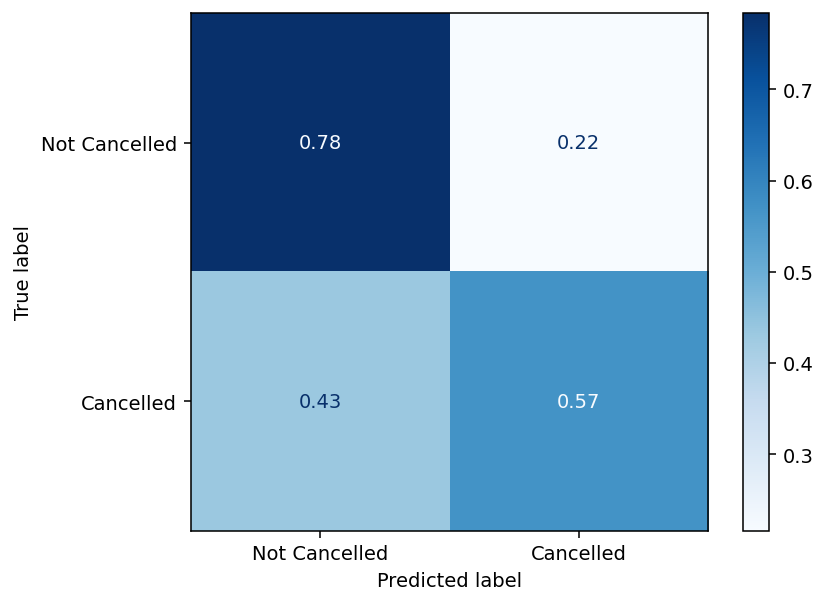

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true")
disp = ConfusionMatrixDisplay(cm, display_labels=["Not Cancelled", "Cancelled"])
disp.plot(cmap=plt.cm.Blues)

## Get feature coefficients for Logistic Regression

Now we are extracting and presenting the feature coefficients obtained from training a Logistic Regression model.

1. **Feature Names Extraction:**
   - The feature names are extracted from the metadata of the 'features' column in the Spark DataFrame using information stored under 'ml_attr.' This information includes the numeric attributes and their names.
   - The resulting feature names are stored in the variable `f_names`.

2. **Feature Coefficient Sorting:**
   - The coefficients obtained from the trained Logistic Regression model are stored in a Pandas DataFrame named `f_imp`. Each coefficient is associated with its corresponding feature.
   - The coefficients are then sorted in descending order by absolute magnitude, and the sorted DataFrame is reassigned to the variable `f_imp`. This sorting helps identify the most influential features in predicting the target variable.


In [ ]:
# Get feature coefficients for Logistic Regression
f_names = features.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]
f_names = [x["name"] for x in f_names]

In [ ]:
f_imp = pd.DataFrame(np.array(models["Logistic Regression"].coefficients), index=f_names).sort_values(by=0, ascending=False)
f_imp

,0
page_pct_lw_Settings,134.527050
page_pct_lw_Help,131.798131
song_length_lw_mean,98.593687
sessions_avg_pages_accessed,74.274544
page_pct_all_Submit Downgrade,71.727723
...,...
sessions_avg_count_artists,-61.428637
song_length_all_mean,-76.379888
page_pct_lw_Submit Downgrade,-77.930804
page_pct_all_Settings,-119.317906


In [ ]:
f_imp = f_imp.abs().sort_values(by=0, ascending=False)
f_imp

,0
page_pct_all_Help,151.253635
page_pct_lw_Settings,134.527050
page_pct_lw_Help,131.798131
page_pct_all_Settings,119.317906
song_length_lw_mean,98.593687
...,...
hourly_song_counts_all_9,0.572218
page_pct_lw_Downgrade,0.336600
hourly_mean_song_length_all_6,0.287642
page_pct_lw_Add to Playlist,0.110383


In [ ]:
# Page Percentage is most relevant and hourly song count the least relevant.

In [ ]:
f_imp.to_csv('coefficients.csv', index=False)


## F1 Comparison Graph for 3 Million Dataset for 2 Nodes v/s 3 Nodes

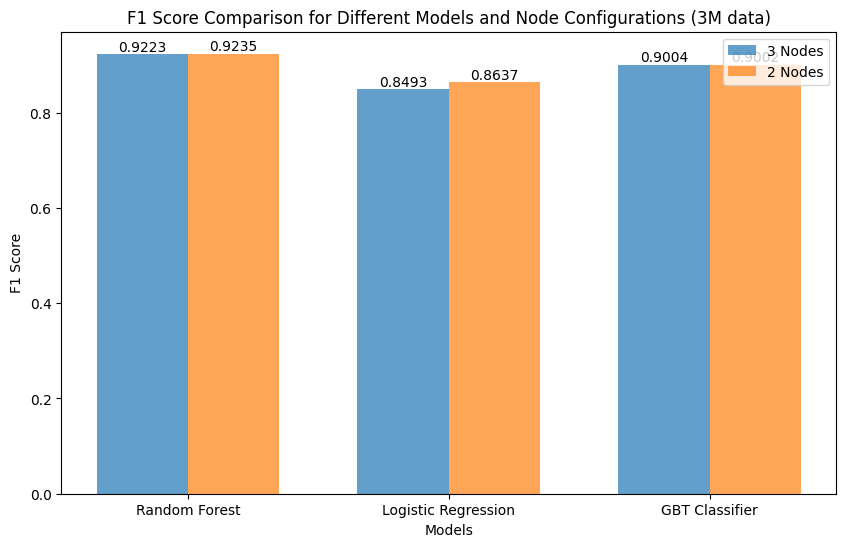

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Random Forest', 'Logistic Regression', 'GBT Classifier']
f1_scores_3_nodes = [0.9223141114003633, 0.8492616712890547, 0.900355973906391]
f1_scores_2_nodes = [0.9235377277902794, 0.8636763133041332, 0.9001905084080977]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
bar_positions = np.arange(len(models))

bar1 = ax.bar(bar_positions, f1_scores_3_nodes, bar_width, label='3 Nodes', alpha=0.7)
bar2 = ax.bar([p + bar_width for p in bar_positions], f1_scores_2_nodes, bar_width, label='2 Nodes', alpha=0.7)

# Adding labels
ax.set_xlabel('Models')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison for Different Models and Node Configurations (3M data)')
ax.set_xticks([p + bar_width / 2 for p in bar_positions])
ax.set_xticklabels(models)
ax.legend()

# Display the F1 scores on top of the bars
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom')

plt.show()
